# Analysis of NOAA ICOADS data

In this notebook, I will provide an analysis of the publically available NOAA International Comprehensive Ocean-Atmosphere Data Set (ICOADS). This dataset contains data collected by ships, buoys and other instruments about ocean/atmosphere properties such as wind direction, atmospheric pressure, but more importantly, sea surface temperature.

As part of this project, I will attempt forecasting sea surface temperatures in regions of the Hudson Bay using frameworks such as XGBoost. As presented below, data is available only in specific regions of the Bay and due to the fact large amounts of data is necessary for such a task, forecasting will be done only within small regions.

In [0]:
creds = "/dbfs/FileStore/tables/causal_destiny_378715_ebcf1c481ef4-1.json"
projectID = "causal-destiny-378715"
base_table = "causal-destiny-378715.mynoaa.icoads_core_"
tables = ["1662_2000", "2001_2004", *[str(year) for year in range(2005,2018)]]
lats = (51,62)
longs = (-95,-76)

## Obtaining the data from Google BigQuery
NOAA ICOADS is currently available as a public dataset available on Google's BigQuery. In this next cell we will pull the data from Google BigQuery and select only the Hudson Bay region and data points more recent than 1950 to ensure higher quality in our data.

In [0]:
from pyspark.sql.functions import col, isnan, when, count, make_date
dfLst = []
for table in tables:
    df = (
        spark.read.format("bigquery")
        .option("credentialsFile", creds)
        .option("parentProject", projectID)
        .option("table", base_table + table)
        .load()
    )
    df = df.select(
        make_date("year", "month", "day").alias("date"), "longitude", "latitude", "sea_surface_temp"
    ).orderBy("date")
    dfLst.append(df)

df = dfLst[0]
for i in range(1, len(dfLst)):
    df = df.union(dfLst[i])
#df = df.select(make_date("year", "month", "day").alias("date"), "hour", "longitude", "latitude", "sea_surface_temp")
df.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable("noaa_icoads")
df.show(5)

+----+---------+--------+----------------+
|date|longitude|latitude|sea_surface_temp|
+----+---------+--------+----------------+
|null|   -128.8|    36.6|            17.0|
|null|    173.5|   -43.5|            16.7|
|null|     42.5|   -23.5|            27.1|
|null|     -9.5|    38.5|            13.2|
|null|    120.5|     8.5|            28.4|
+----+---------+--------+----------------+
only showing top 5 rows



In the cell above, we saved the entirety of the NOAA ICOADS data for the date, longitude, latitude and sea_surface_temperature features.
In the cell below, we save the data to Databricks SQL server, which will allow us to quickly reuse the data as needed. It saves a daily global average sea surface temperature (for future use).

In [0]:
spark.sql('CREATE TABLE noaa_icoads_agg AS (SELECT date, AVG(sea_surface_temp) AS avg_global_sst FROM noaa_icoads GROUP BY date ORDER BY date)')

Out[1]: DataFrame[num_affected_rows: bigint, num_inserted_rows: bigint]

In this cell below, we select the proper data within the Hudson's bay.

In [0]:
df = spark.sql('SELECT * FROM noaa_icoads WHERE (latitude BETWEEN 51 AND 62) AND (longitude BETWEEN -95 AND -76) ORDER BY date, longitude, latitude')


## Visualizing the data
Using [this code](https://www.kaggle.com/code/ihromov/basic-analysis-of-noaa-icoads), we can preview the data that we will cover:

![Data Preview](files/tables/datapreview-1.png)

Our data is denoted by the dark blue areas.
Unfortunately, I was unable to run this data preview here on Databricks due to issues with `mpl_toolkits`.

## Validity Analysis

### Null values
Let us have a look at the data we have collected to see if it is well-behaved enough to perform machine learning on it. First of all let us ensure that our data contains no null values

In [0]:
from pyspark.sql.functions import col, isnan, when, count, make_date
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull(), c \
                           )).alias(c)
                    for c in df.columns]) \
        .show()

+----+-----+---+----+---------+--------+----------------+
|year|month|day|hour|longitude|latitude|sea_surface_temp|
+----+-----+---+----+---------+--------+----------------+
|   0|    0|  0|   0|        0|       0|               0|
+----+-----+---+----+---------+--------+----------------+



### Data quantity
We then verify the amount of data we have to see if there is grounds to run machine learning

In [0]:
df3 = df.select(count("sea_surface_temp")) \
    .show()

+-----------------------+
|count(sea_surface_temp)|
+-----------------------+
|                  20194|
+-----------------------+



### Time distribution
We then have a look at how the data is distributed through time.

In [0]:
from pyspark.sql.functions import col, isnan, when, count, make_date
import pandas as pd
df4 = df.groupBy("year") \
    .agg(count("sea_surface_temp").alias("measurement_count")) \
    .orderBy("year").toPandas() 

Out[6]: <AxesSubplot:xlabel='year'>

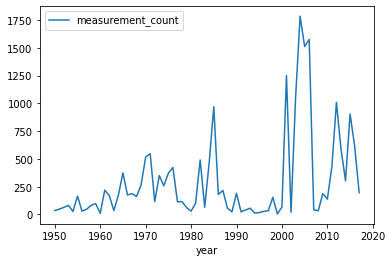

In [0]:
df4.plot.line(x="year", y="measurement_count")

We see that most of the data was taken around 2005, with some peaks here and there.

In [0]:
df5 = df.groupBy("month") \
    .agg(count("sea_surface_temp").alias("measurement_count")) \
    .orderBy("month").toPandas() 

We then have a look at how the data is distributed through each year

Out[8]: <AxesSubplot:xlabel='month'>

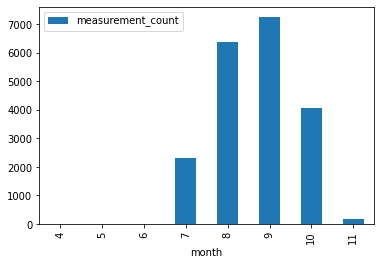

In [0]:
df5.plot.bar(x="month", y="measurement_count")

As we can see, most of the data were taken between July and November. This is not great because this will result in skewed forecasting. In order to avoid this, we could either forecast sea surface temperatures for only these months, or we could take a larger scope in order to have better data distribution.

## Rescoping

In order to improve the validity of the forecasting, let's increase the scope by looking at a better feature. Instead of looking at measurements taken only within the Hudson's Bay, let's have a look at the global average daily sea surface temperature. This data was already saved in the SQL server as the 'noaa_icoads_agg' table. We will need to have a second look at the validity of this data.

## Validity Analysis (Rescoped)

### Null values

In [0]:
from pyspark.sql.functions import col, isnan, when, count, make_date
ndf = spark.sql('SELECT * FROM noaa_icoads_agg')
ndf.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull(), c \
                           )).alias(c)
                    for c in ndf.columns]) \
        .show()

+----+--------------+
|date|avg_global_sst|
+----+--------------+
|   1|             0|
+----+--------------+



### Data quantity

In [0]:
spark.sql('SELECT COUNT(*) FROM noaa_icoads_agg').show()

+--------+
|count(1)|
+--------+
|   70227|
+--------+



### Time distribution

Out[3]: <AxesSubplot:xlabel='year'>

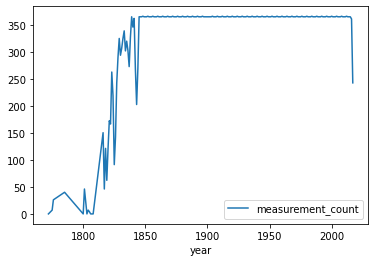

In [0]:
spark.sql('SELECT YEAR(date) as year, COUNT(avg_global_sst) as measurement_count FROM noaa_icoads_agg GROUP BY year ORDER BY year').toPandas().plot.line(x='year', y='measurement_count')

The data in this aggregated global average SST was already grouped by day. Therefore, 365 is essentially the largest count a year can have (every day has a measurement). Therefore, we have data for every day for the past 150 years.

Out[4]: <AxesSubplot:xlabel='month'>

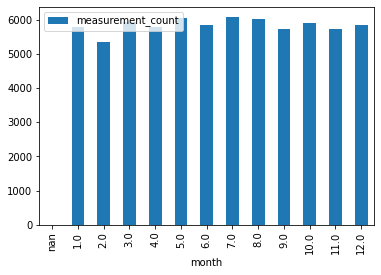

In [0]:
spark.sql('SELECT MONTH(date) as month, COUNT(avg_global_sst) as measurement_count FROM noaa_icoads_agg GROUP BY month ORDER BY month').toPandas().plot.bar(x='month', y='measurement_count')

As we can see, we have approximately equal data for each month of the year. At this point, we know the data is well behaved and we are ready to proceed to the machine learning section.

# Machine learning

Now that we've checked that this data is well-behaved, we will use features of Databricks to easily forecast global average temperature. Once our data is saved as a table, we can use Databricks AutoML experiments to create a forecasting model.

Databricks AutoML is a feature that automates the process of building, training, and deploying machine learning models, including forecasting models. It includes automated data preparation, feature engineering, model selection, hyperparameter tuning, and model evaluation. Users can specify their data sources and desired performance metrics through a simple web interface, and Databricks automatically performs the necessary steps to generate an optimal forecasting model. Once the model is trained, it can be easily deployed into production using REST APIs, batch inference, or streaming inference.

Specifically, for forecasting, AutoML uses Facebook's "Prophet". Prophet is a time series forecasting library developed by Facebook that uses a decomposable model with trend, seasonality, and holiday components. For this example, we do not use the holiday component but the seasonality is quite important. This model includes advanced features like changepoint detection and Bayesian uncertainty estimation, is highly customizable, and integrates easily with Python and R. It makes it easy for analysts and data scientists to produce high-quality forecasts with minimal effort.

By using AutoML, several models were built and the one with highest accuracy was used to forecast the global average SST.